Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Behavioral Cloning
1.  Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral
cloning agent achieves comparable performance to the expert, and one task where it does not.  When
providing  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a
table, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,
amount of data, and number of training iterations, and provide these details (and any others you feel
are appropriate) in the table caption.
1
2.  Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself.  For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [1]:
import gym
 
env = gym.make('Hopper-v1')

[2017-11-02 11:17:30,594] Making new env: Hopper-v1


In [2]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [3]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size,dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [4]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [47]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

minibatch_size = 4

def learn_imitatation_learning(ffn, args):
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % minibatch_size == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-minibatch_size:])), 
                                         Variable(torch.Tensor(np.array(actions[-minibatch_size:])[:,0,:])),
                                         learning_rate
                                        )
                    #print("%i/%i, Error %f"%(steps, max_steps,error))
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

#         expert_data = {'observations': np.array(observations),
#                        'actions': np.array(actions)}
        return returns,error
        

#Evaluate learned policy
def evaluate_imitation_learning(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

#     print('returns', returns)
#     print('mean return', np.mean(returns))
#     print('std of return', np.std(returns))

#     expert_data = {'observations': np.array(observations),
#                    'actions': np.array(actions)}
        ffn.dropout_rate = dropout_rate
        return returns


### Train loop

In [57]:
learning_rate = 1e-2

envname = 'Ant-v1'
env = gym.make(envname)
#with gym.make(envname) as env:
state_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]

print('Starting {} environment. State space dim (), action space dim {}.'.format(
    envname,
    state_shape,
    actions_shape)
     )

#ffn = FFN(state_shape, 128, 64,actions_shape,dropout_rate = 0)

learn_args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })


eval_args = pd.Series({
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })

n_iter = 300

results = []
for i in range(n_iter):
    experts_returns, error = learn_imitatation_learning(ffn, learn_args)
    agent_returns   = evaluate_imitation_learning(ffn, eval_args)
    print(i, np.mean(experts_returns),np.mean(error), np.mean(agent_returns),np.std(agent_returns))
    results.append((np.mean(experts_returns),np.mean(error),np.mean(agent_returns),np.std(agent_returns)))


[2017-11-02 13:34:57,339] Making new env: Ant-v1


Starting Ant-v1 environment. State space dim (), action space dim 111.
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:34:57,400] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:34:57,413] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:34:59,518] Making new env: Ant-v1
[2017-11-02 13:35:12,456] Making new env: Ant-v1


0 4904.21821588 0.0274758711457 740.704619757 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:35:17,123] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:35:17,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:35:19,219] Making new env: Ant-v1
[2017-11-02 13:35:27,139] Making new env: Ant-v1


1 4855.97380714 0.0356882587075 1642.33568288 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:35:28,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:35:28,091] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:35:29,482] Making new env: Ant-v1
[2017-11-02 13:35:35,939] Making new env: Ant-v1


2 4878.38084532 0.0738695934415 892.311638591 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:35:38,972] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:35:38,983] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:35:39,908] Making new env: Ant-v1
[2017-11-02 13:35:44,558] Making new env: Ant-v1


3 4852.73266321 0.0548080801964 674.620122602 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:35:47,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:35:47,492] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:35:49,022] Making new env: Ant-v1
[2017-11-02 13:35:57,295] Making new env: Ant-v1


4 4793.2169757 0.0787877142429 11.4941162505 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:35:57,356] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:35:57,367] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:35:58,343] Making new env: Ant-v1
[2017-11-02 13:36:05,213] Making new env: Ant-v1


5 4821.22274534 0.0909691154957 1688.84213078 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:36:08,084] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:36:08,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:36:09,152] Making new env: Ant-v1
[2017-11-02 13:36:15,199] Making new env: Ant-v1


6 4739.44821064 0.0604154057801 2619.98031663 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:36:18,736] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:36:18,761] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:36:20,261] Making new env: Ant-v1
[2017-11-02 13:36:27,893] Making new env: Ant-v1


7 4753.1621011 0.0393764078617 3833.88286027 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:36:31,298] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:36:31,311] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:36:32,821] Making new env: Ant-v1
[2017-11-02 13:36:38,683] Making new env: Ant-v1


8 4864.11770657 0.0497647449374 2184.13794576 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:36:45,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:36:45,174] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:36:46,728] Making new env: Ant-v1
[2017-11-02 13:36:53,140] Making new env: Ant-v1


9 4845.67227897 0.0413191616535 725.229165622 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:36:55,680] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:36:55,692] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:36:56,544] Making new env: Ant-v1
[2017-11-02 13:37:01,812] Making new env: Ant-v1


10 4742.497239 0.043227430433 2485.81537891 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:37:07,383] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:37:07,393] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:37:09,151] Making new env: Ant-v1
[2017-11-02 13:37:19,534] Making new env: Ant-v1


11 4905.55002122 0.058706972748 2130.79092717 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:37:24,511] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:37:24,526] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:37:26,671] Making new env: Ant-v1
[2017-11-02 13:37:33,194] Making new env: Ant-v1


12 4826.22781864 0.0463807433844 4050.75653131 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:37:35,560] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:37:35,578] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:37:37,243] Making new env: Ant-v1
[2017-11-02 13:37:42,207] Making new env: Ant-v1


13 4808.98171229 0.0705751851201 747.263497481 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:37:45,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:37:45,420] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:37:46,793] Making new env: Ant-v1
[2017-11-02 13:37:55,642] Making new env: Ant-v1


14 4923.39024048 0.116497069597 465.512990928 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:37:56,385] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:37:56,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:37:59,642] Making new env: Ant-v1
[2017-11-02 13:38:18,599] Making new env: Ant-v1


15 4718.23495271 0.0708393678069 1677.57204075 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:21,470] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:21,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:23,498] Making new env: Ant-v1
[2017-11-02 13:38:30,199] Making new env: Ant-v1


16 4714.41831509 0.0408257879317 729.718080914 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:38:39,710] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:38:39,730] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:38:42,500] Making new env: Ant-v1
[2017-11-02 13:39:05,102] Making new env: Ant-v1


17 4729.80016487 0.10755071044 2113.55153096 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:39:14,811] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:39:14,830] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:39:19,165] Making new env: Ant-v1
[2017-11-02 13:39:49,227] Making new env: Ant-v1


18 4811.16953879 0.0267021879554 3406.28386911 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:00,210] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:00,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:06,525] Making new env: Ant-v1
[2017-11-02 13:40:36,347] Making new env: Ant-v1


19 4791.93313277 0.0329648964107 654.338549637 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:40:50,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:40:50,259] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:40:53,988] Making new env: Ant-v1
[2017-11-02 13:41:14,085] Making new env: Ant-v1


20 4863.32809895 0.0446906723082 3780.97832093 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:21,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:21,829] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:25,243] Making new env: Ant-v1
[2017-11-02 13:41:44,175] Making new env: Ant-v1


21 4851.35746701 0.0358702279627 4269.35936926 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:41:51,519] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:41:51,542] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:41:55,034] Making new env: Ant-v1
[2017-11-02 13:42:14,398] Making new env: Ant-v1


22 4798.20087086 0.0428059473634 4033.17898133 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:22,391] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:22,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:26,010] Making new env: Ant-v1
[2017-11-02 13:42:45,045] Making new env: Ant-v1


23 4718.28132686 0.0913939476013 2659.68792138 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:42:53,023] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:42:53,043] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:42:56,441] Making new env: Ant-v1
[2017-11-02 13:43:16,732] Making new env: Ant-v1


24 4889.69303823 0.111460201442 4409.07448052 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:24,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:24,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:27,448] Making new env: Ant-v1
[2017-11-02 13:43:45,982] Making new env: Ant-v1


25 4779.25855307 0.0474546849728 1775.18141524 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:43:54,362] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:43:54,382] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:43:57,811] Making new env: Ant-v1
[2017-11-02 13:44:16,669] Making new env: Ant-v1


26 4850.34205103 0.0789253562689 3848.63247721 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:24,021] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:24,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:27,361] Making new env: Ant-v1
[2017-11-02 13:44:45,781] Making new env: Ant-v1


27 4729.90616722 0.0366659164429 3065.88272312 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:44:53,364] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:44:53,385] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:44:56,841] Making new env: Ant-v1
[2017-11-02 13:45:16,925] Making new env: Ant-v1


28 4934.21618455 0.0383401960135 3480.66912625 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:45:24,392] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:45:24,414] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:45:28,859] Making new env: Ant-v1
[2017-11-02 13:45:54,458] Making new env: Ant-v1


29 4744.52535032 0.0283362232149 952.95903014 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:05,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:05,217] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:09,587] Making new env: Ant-v1
[2017-11-02 13:46:34,478] Making new env: Ant-v1


30 4843.15273591 0.0785314589739 3130.42977135 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:46:43,127] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:46:43,149] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:46:47,454] Making new env: Ant-v1
[2017-11-02 13:47:12,679] Making new env: Ant-v1


31 4766.10741036 0.106097176671 2248.98344271 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:19,531] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:19,550] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:24,151] Making new env: Ant-v1
[2017-11-02 13:47:48,832] Making new env: Ant-v1


32 4754.3983377 0.0234603639692 2705.10633426 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:47:55,455] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:47:55,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:47:59,814] Making new env: Ant-v1
[2017-11-02 13:48:19,761] Making new env: Ant-v1


33 4847.35330228 0.0558994784951 2877.78133111 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:27,507] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:27,534] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:48:30,950] Making new env: Ant-v1
[2017-11-02 13:48:49,881] Making new env: Ant-v1


34 4733.68074511 0.0403700321913 3748.79665649 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:48:57,233] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:48:57,251] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:00,696] Making new env: Ant-v1
[2017-11-02 13:49:20,505] Making new env: Ant-v1


35 4903.36080849 0.032035831362 721.23932754 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:29,343] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:29,388] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:33,090] Making new env: Ant-v1
[2017-11-02 13:49:50,234] Making new env: Ant-v1


36 4926.923442 0.0421678945422 1671.96656741 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:49:53,267] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:49:53,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:49:56,338] Making new env: Ant-v1
[2017-11-02 13:50:12,484] Making new env: Ant-v1


37 4628.27701144 0.055607393384 3384.38149102 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:19,229] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:19,250] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:22,283] Making new env: Ant-v1
[2017-11-02 13:50:38,363] Making new env: Ant-v1


38 4762.86930466 0.0514180883765 3926.9221838 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:50:44,667] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:50:44,694] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:50:47,734] Making new env: Ant-v1
[2017-11-02 13:51:03,978] Making new env: Ant-v1


39 4751.45117536 0.144581273198 1471.26975795 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:11,394] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:11,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:14,821] Making new env: Ant-v1
[2017-11-02 13:51:30,943] Making new env: Ant-v1


40 4776.41668882 0.0783481448889 1271.52990028 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:33,143] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:33,159] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:51:36,184] Making new env: Ant-v1
[2017-11-02 13:51:52,099] Making new env: Ant-v1


41 4678.32440441 0.0285145305097 2652.01224038 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:51:58,860] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:51:58,874] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:01,969] Making new env: Ant-v1
[2017-11-02 13:52:18,398] Making new env: Ant-v1


42 4919.525234 0.0575525909662 3699.31859322 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:24,776] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:24,793] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:27,818] Making new env: Ant-v1
[2017-11-02 13:52:47,543] Making new env: Ant-v1


43 4929.90220733 0.0396551042795 1566.40830145 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:52:55,180] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:52:55,200] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:52:58,330] Making new env: Ant-v1
[2017-11-02 13:53:15,442] Making new env: Ant-v1


44 4834.07607103 0.0410719811916 2570.25579284 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:22,475] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:22,498] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:25,595] Making new env: Ant-v1
[2017-11-02 13:53:41,705] Making new env: Ant-v1


45 4875.70436824 0.0883111134171 745.465611748 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:53:49,060] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:53:49,080] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:53:52,194] Making new env: Ant-v1
[2017-11-02 13:54:08,756] Making new env: Ant-v1


46 4816.06274048 0.0563857965171 4186.80116879 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:15,271] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:15,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:18,923] Making new env: Ant-v1
[2017-11-02 13:54:35,190] Making new env: Ant-v1


47 4905.97532 0.0351193994284 2755.15516129 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:54:39,455] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:54:39,474] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:54:42,451] Making new env: Ant-v1
[2017-11-02 13:54:58,509] Making new env: Ant-v1


48 4736.38967416 0.0474239848554 3771.2474996 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:05,151] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:05,173] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:08,171] Making new env: Ant-v1
[2017-11-02 13:55:25,162] Making new env: Ant-v1


49 4864.11401726 0.077504016459 4329.86424479 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:31,866] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:31,885] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:34,886] Making new env: Ant-v1
[2017-11-02 13:55:51,533] Making new env: Ant-v1


50 4822.34368164 0.0643845126033 609.780645678 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:55:54,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:55:54,244] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:55:57,403] Making new env: Ant-v1
[2017-11-02 13:56:13,828] Making new env: Ant-v1


51 4935.66652694 0.0267112758011 2858.03216407 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:21,386] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:21,405] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:24,501] Making new env: Ant-v1
[2017-11-02 13:56:40,721] Making new env: Ant-v1


52 4744.51107855 0.0566101185977 992.213262468 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:56:48,742] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:56:48,766] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:56:51,853] Making new env: Ant-v1
[2017-11-02 13:57:08,235] Making new env: Ant-v1


53 4722.55496602 0.0560251250863 1533.59892946 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:16,402] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:16,423] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:19,389] Making new env: Ant-v1
[2017-11-02 13:57:35,405] Making new env: Ant-v1


54 4826.87356521 0.0374245755374 1271.72453289 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:57:43,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:57:43,035] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:57:46,151] Making new env: Ant-v1
[2017-11-02 13:58:02,451] Making new env: Ant-v1


55 4794.99769999 0.0255405642092 124.312481136 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:02,919] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:02,935] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:05,920] Making new env: Ant-v1
[2017-11-02 13:58:22,721] Making new env: Ant-v1


56 4747.29536123 0.0496651902795 544.330311533 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:23,775] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:23,789] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:26,981] Making new env: Ant-v1
[2017-11-02 13:58:42,764] Making new env: Ant-v1


57 4681.37180792 0.0739877894521 3121.95212452 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:58:49,762] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:58:49,781] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:58:52,819] Making new env: Ant-v1
[2017-11-02 13:59:08,708] Making new env: Ant-v1


58 4808.04526642 0.0409637205303 1335.9444667 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:17,084] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:17,108] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:20,183] Making new env: Ant-v1
[2017-11-02 13:59:36,208] Making new env: Ant-v1


59 4851.83287252 0.0385022386909 3094.87969662 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 13:59:42,734] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 13:59:42,753] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 13:59:45,780] Making new env: Ant-v1
[2017-11-02 14:00:02,049] Making new env: Ant-v1


60 4768.3744157 0.0480093881488 3686.63375694 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:08,405] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:08,422] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:11,488] Making new env: Ant-v1
[2017-11-02 14:00:28,090] Making new env: Ant-v1


61 4837.16638476 0.0519790500402 3011.25395491 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:34,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:34,561] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:00:37,563] Making new env: Ant-v1
[2017-11-02 14:00:53,304] Making new env: Ant-v1


62 4856.87820129 0.0471603423357 4096.91061329 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:00:59,748] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:00:59,771] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:03,077] Making new env: Ant-v1
[2017-11-02 14:01:20,284] Making new env: Ant-v1


63 4773.29247294 0.0614497959614 823.180178679 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:27,990] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:28,005] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:31,177] Making new env: Ant-v1
[2017-11-02 14:01:47,108] Making new env: Ant-v1


64 4668.25140801 0.0586252845824 3556.91462525 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:01:53,619] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:01:53,641] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:01:56,740] Making new env: Ant-v1
[2017-11-02 14:02:12,906] Making new env: Ant-v1


65 4856.67853952 0.0448830202222 3540.21038939 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:20,100] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:20,116] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:23,377] Making new env: Ant-v1
[2017-11-02 14:02:39,487] Making new env: Ant-v1


66 4779.51666514 0.0539294406772 4091.87576828 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:02:45,792] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:02:45,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:02:49,000] Making new env: Ant-v1
[2017-11-02 14:03:05,717] Making new env: Ant-v1


67 4744.84190529 0.0364018753171 3511.97062664 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:12,330] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:12,332] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:16,150] Making new env: Ant-v1
[2017-11-02 14:03:32,200] Making new env: Ant-v1


68 4809.36872939 0.0523343533278 4222.15161495 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:03:38,380] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:03:38,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:03:41,534] Making new env: Ant-v1
[2017-11-02 14:03:57,665] Making new env: Ant-v1


69 4710.95603388 0.02645271644 4455.84953712 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:04,178] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:04,195] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:07,493] Making new env: Ant-v1
[2017-11-02 14:04:24,185] Making new env: Ant-v1


70 4817.00538492 0.0334889851511 279.267555745 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:24,837] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:24,852] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:27,946] Making new env: Ant-v1
[2017-11-02 14:04:44,367] Making new env: Ant-v1


71 4804.6053126 0.0300306454301 898.97242078 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:04:52,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:04:52,259] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:04:55,368] Making new env: Ant-v1
[2017-11-02 14:05:11,865] Making new env: Ant-v1


72 4866.4839325 0.0260367952287 3845.30588559 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:19,107] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:19,126] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:22,334] Making new env: Ant-v1
[2017-11-02 14:05:38,152] Making new env: Ant-v1


73 4860.91558816 0.0673123672605 2890.44941996 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:05:45,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:05:45,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:05:48,637] Making new env: Ant-v1
[2017-11-02 14:05:59,344] Making new env: Ant-v1


74 3051.33314719 0.0364213660359 1391.10404293 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:01,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:01,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:04,728] Making new env: Ant-v1
[2017-11-02 14:06:21,516] Making new env: Ant-v1


75 4849.09204274 0.0390746109188 1307.07892777 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:29,271] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:29,282] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:32,446] Making new env: Ant-v1
[2017-11-02 14:06:48,375] Making new env: Ant-v1


76 4860.32545833 0.0502625927329 4380.90374729 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:06:54,683] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:06:54,705] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:06:57,932] Making new env: Ant-v1
[2017-11-02 14:07:15,383] Making new env: Ant-v1


77 4892.45423911 0.0435393452644 367.396022388 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:16,415] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:16,433] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:19,623] Making new env: Ant-v1
[2017-11-02 14:07:35,979] Making new env: Ant-v1


78 4787.46711827 0.0668923258781 4156.41970886 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 14:07:44,460] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 14:07:44,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 14:07:47,712] Making new env: Ant-v1
[2017-11-02 14:08:05,064] Making new env: Ant-v1


79 4773.09212943 0.0728744789958 3885.80761348 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:10:44,685] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:10:44,700] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:10:48,068] Making new env: Ant-v1
[2017-11-02 16:11:02,953] Making new env: Ant-v1


80 4963.3272504 0.0304156467319 2912.72213226 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:07,693] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:07,705] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:11,220] Making new env: Ant-v1
[2017-11-02 16:11:29,358] Making new env: Ant-v1


81 4801.44644165 0.0588659420609 744.840785237 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:11:37,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:11:37,627] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:11:40,600] Making new env: Ant-v1
[2017-11-02 16:11:56,965] Making new env: Ant-v1


82 4860.6311792 0.0253287665546 1868.36988057 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:05,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:05,459] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:09,107] Making new env: Ant-v1
[2017-11-02 16:12:24,378] Making new env: Ant-v1


83 4946.91041217 0.0237969867885 200.045581208 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:25,205] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:25,228] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:28,304] Making new env: Ant-v1
[2017-11-02 16:12:45,103] Making new env: Ant-v1


84 4763.00680971 0.0762736201286 992.478281742 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:12:53,205] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:12:53,218] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:12:56,485] Making new env: Ant-v1
[2017-11-02 16:13:13,803] Making new env: Ant-v1


85 4817.88576568 0.0535474717617 3872.93401658 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:22,453] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:22,473] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:26,151] Making new env: Ant-v1
[2017-11-02 16:13:47,676] Making new env: Ant-v1


86 4842.54105395 0.0447205379605 709.847221444 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:13:56,074] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:13:56,092] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:13:59,531] Making new env: Ant-v1
[2017-11-02 16:14:16,740] Making new env: Ant-v1


87 4848.04795893 0.033409960568 4225.2900277 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:22,878] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:22,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:14:26,238] Making new env: Ant-v1
[2017-11-02 16:14:47,174] Making new env: Ant-v1


88 4749.33855091 0.0503674075007 1103.87228757 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:14:57,679] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:14:57,704] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:02,466] Making new env: Ant-v1
[2017-11-02 16:15:20,000] Making new env: Ant-v1


89 4822.27254798 0.0410892441869 4409.58686205 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:26,418] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:26,433] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:15:29,865] Making new env: Ant-v1
[2017-11-02 16:15:49,051] Making new env: Ant-v1


90 4847.78489639 0.0605244375765 3503.02705825 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:15:56,987] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:15:56,999] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:01,223] Making new env: Ant-v1
[2017-11-02 16:16:20,672] Making new env: Ant-v1


91 4877.22312837 0.0341819189489 831.006627437 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:29,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:29,059] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:31,161] Making new env: Ant-v1
[2017-11-02 16:16:41,580] Making new env: Ant-v1


92 4840.01359101 0.0619215480983 4152.78978635 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:16:45,684] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:16:45,700] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:16:47,840] Making new env: Ant-v1
[2017-11-02 16:16:57,850] Making new env: Ant-v1


93 4932.83081078 0.0577188879251 2407.19364548 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:02,214] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:02,224] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:04,261] Making new env: Ant-v1
[2017-11-02 16:17:14,755] Making new env: Ant-v1


94 4714.9434739 0.10687918961 4440.97498852 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:19,148] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:19,167] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:21,461] Making new env: Ant-v1
[2017-11-02 16:17:31,688] Making new env: Ant-v1


95 4746.66117911 0.055756047368 4420.45199078 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:35,494] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:35,507] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:37,381] Making new env: Ant-v1
[2017-11-02 16:17:42,263] Making new env: Ant-v1


96 2492.32208551 0.106576003134 4032.63050985 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:17:46,376] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:17:46,388] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:17:48,182] Making new env: Ant-v1
[2017-11-02 16:17:58,074] Making new env: Ant-v1


97 4858.36278909 0.0455155037344 4716.51379675 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:01,805] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:01,817] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:03,623] Making new env: Ant-v1
[2017-11-02 16:18:12,190] Making new env: Ant-v1


98 4686.05351079 0.0355223454535 3087.06450085 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:15,905] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:15,920] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:17,725] Making new env: Ant-v1
[2017-11-02 16:18:26,540] Making new env: Ant-v1


99 4840.11540226 0.0228638481349 410.727063123 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:27,010] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:27,023] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:28,802] Making new env: Ant-v1
[2017-11-02 16:18:37,224] Making new env: Ant-v1


100 4941.34560753 0.0294952131808 4776.44983966 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:40,608] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:40,622] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:42,386] Making new env: Ant-v1
[2017-11-02 16:18:50,975] Making new env: Ant-v1


101 4773.20100077 0.0531658791006 4285.68155539 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:18:54,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:18:54,365] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:18:56,136] Making new env: Ant-v1
[2017-11-02 16:19:04,806] Making new env: Ant-v1


102 4826.71597236 0.0763011947274 4335.15000863 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:08,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:08,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:09,883] Making new env: Ant-v1
[2017-11-02 16:19:18,135] Making new env: Ant-v1


103 4668.20184373 0.0836729854345 4437.18737519 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:21,463] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:21,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:24,517] Making new env: Ant-v1
[2017-11-02 16:19:40,533] Making new env: Ant-v1


104 4948.10895225 0.0297206714749 3656.72531528 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:19:44,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:19:44,381] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:19:46,691] Making new env: Ant-v1
[2017-11-02 16:19:56,941] Making new env: Ant-v1


105 4831.39854054 0.0434146821499 4015.58324999 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:02,265] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:02,283] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:05,929] Making new env: Ant-v1
[2017-11-02 16:20:16,673] Making new env: Ant-v1


106 4868.76965262 0.0598589591682 3476.3799646 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:21,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:21,436] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:23,832] Making new env: Ant-v1
[2017-11-02 16:20:36,665] Making new env: Ant-v1


107 4777.07119194 0.0662072747946 3502.3602265 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:40,848] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:40,862] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:43,097] Making new env: Ant-v1
[2017-11-02 16:20:54,031] Making new env: Ant-v1


108 4758.34254817 0.0543486811221 4013.41071823 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:00,175] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:00,196] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:03,003] Making new env: Ant-v1
[2017-11-02 16:21:18,312] Making new env: Ant-v1


109 4854.04740738 0.0744034200907 4596.23161026 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:25,616] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:25,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:28,901] Making new env: Ant-v1
[2017-11-02 16:21:44,879] Making new env: Ant-v1


110 4196.28398514 0.0250403545797 4281.29502996 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:51,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:51,990] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:55,722] Making new env: Ant-v1
[2017-11-02 16:22:14,091] Making new env: Ant-v1


111 4784.56929481 0.0479604378343 4094.16159511 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:21,098] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:21,117] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:24,373] Making new env: Ant-v1
[2017-11-02 16:22:42,750] Making new env: Ant-v1


112 4807.83801076 0.0488667972386 1586.97488758 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:45,451] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:45,464] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:48,707] Making new env: Ant-v1
[2017-11-02 16:23:03,904] Making new env: Ant-v1


113 4749.13447536 0.0413552708924 3791.34341818 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:09,494] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:09,515] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:12,302] Making new env: Ant-v1
[2017-11-02 16:23:25,367] Making new env: Ant-v1


114 4756.87504684 0.0643202289939 2824.07647846 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:31,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:31,392] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:34,088] Making new env: Ant-v1
[2017-11-02 16:23:48,489] Making new env: Ant-v1


115 4726.59983166 0.0503402464092 4468.99903113 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:54,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:54,514] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:57,541] Making new env: Ant-v1
[2017-11-02 16:24:14,369] Making new env: Ant-v1


116 3566.9168117 0.0813543125987 722.801946348 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:21,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:21,344] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:24,508] Making new env: Ant-v1
[2017-11-02 16:24:40,832] Making new env: Ant-v1


117 4824.23347463 0.0811204686761 1151.4219997 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:48,310] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:48,326] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:51,510] Making new env: Ant-v1
[2017-11-02 16:25:07,847] Making new env: Ant-v1


118 4936.95125851 0.0406240969896 4306.37204756 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:14,137] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:14,159] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:17,296] Making new env: Ant-v1
[2017-11-02 16:25:36,543] Making new env: Ant-v1


119 4930.63230773 0.0398904308677 4483.03601853 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:44,844] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:44,850] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:48,961] Making new env: Ant-v1
[2017-11-02 16:26:08,702] Making new env: Ant-v1


120 4757.88497805 0.0548870489001 2679.67990525 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:17,256] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:17,277] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:20,848] Making new env: Ant-v1
[2017-11-02 16:26:40,027] Making new env: Ant-v1


121 4832.7414217 0.0591167658567 4204.04813901 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:47,168] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:47,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:51,072] Making new env: Ant-v1
[2017-11-02 16:27:09,661] Making new env: Ant-v1


122 4716.56450463 0.0273380726576 3586.77423692 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:17,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:17,344] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:21,049] Making new env: Ant-v1
[2017-11-02 16:27:39,877] Making new env: Ant-v1


123 4816.18360899 0.0344567149878 3755.18493269 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:47,824] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:47,843] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:51,516] Making new env: Ant-v1
[2017-11-02 16:28:11,784] Making new env: Ant-v1


124 4855.59792536 0.0299307852983 2264.11894429 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:15,302] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:15,321] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:19,205] Making new env: Ant-v1
[2017-11-02 16:28:38,126] Making new env: Ant-v1


125 4665.30599322 0.0638447627425 3861.75700879 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:45,355] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:45,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:49,035] Making new env: Ant-v1
[2017-11-02 16:29:07,836] Making new env: Ant-v1


126 4943.44283861 0.0222298949957 4143.41754929 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:15,098] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:15,118] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:18,818] Making new env: Ant-v1
[2017-11-02 16:29:29,508] Making new env: Ant-v1


127 2644.08351748 0.121208146214 3074.91058839 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:37,149] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:37,171] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:40,826] Making new env: Ant-v1
[2017-11-02 16:30:00,631] Making new env: Ant-v1


128 4894.41229412 0.056946773082 3834.66791027 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:07,876] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:07,894] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:11,888] Making new env: Ant-v1
[2017-11-02 16:30:30,224] Making new env: Ant-v1


129 4925.10666384 0.0461692586541 3986.51526697 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:38,098] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:38,125] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:42,132] Making new env: Ant-v1
[2017-11-02 16:31:06,818] Making new env: Ant-v1


130 4876.67652636 0.0355616621673 2842.84045377 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:16,890] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:16,915] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:21,587] Making new env: Ant-v1
[2017-11-02 16:31:37,601] Making new env: Ant-v1


131 3161.43068771 0.0432149022818 4258.77776623 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:47,608] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:47,626] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:52,381] Making new env: Ant-v1
[2017-11-02 16:32:18,707] Making new env: Ant-v1


132 4762.904797 0.0437569431961 4093.23324504 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:28,603] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:28,622] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:33,411] Making new env: Ant-v1
[2017-11-02 16:32:58,707] Making new env: Ant-v1


133 4841.57344676 0.0410260818899 4005.9448363 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:08,432] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:08,456] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:13,320] Making new env: Ant-v1
[2017-11-02 16:33:37,244] Making new env: Ant-v1


134 4775.99678414 0.0314420685172 4316.9088009 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:47,229] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:47,241] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:52,352] Making new env: Ant-v1
[2017-11-02 16:34:17,507] Making new env: Ant-v1


135 4782.48670354 0.0320728942752 4438.72900381 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:26,773] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:26,798] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:31,637] Making new env: Ant-v1
[2017-11-02 16:34:56,517] Making new env: Ant-v1


136 4740.1057911 0.0340940989554 1763.71800369 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:06,416] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:06,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:10,914] Making new env: Ant-v1
[2017-11-02 16:35:33,031] Making new env: Ant-v1


137 4766.94561036 0.0511513352394 3837.8081549 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:41,970] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:41,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:46,851] Making new env: Ant-v1
[2017-11-02 16:36:08,940] Making new env: Ant-v1


138 4683.65740132 0.0418270006776 14.2646964739 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:09,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:09,252] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:13,531] Making new env: Ant-v1
[2017-11-02 16:36:36,837] Making new env: Ant-v1


139 4731.25341699 0.0449953377247 4456.03693689 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:45,061] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:45,083] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:49,526] Making new env: Ant-v1
[2017-11-02 16:37:10,856] Making new env: Ant-v1


140 4913.15435361 0.0397673547268 4189.83927106 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:19,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:19,208] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:23,767] Making new env: Ant-v1
[2017-11-02 16:37:45,222] Making new env: Ant-v1


141 4879.47895207 0.0567713342607 4364.88390447 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:54,365] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:54,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:58,964] Making new env: Ant-v1
[2017-11-02 16:38:23,951] Making new env: Ant-v1


142 4827.58547886 0.0352297201753 2242.48542216 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:28,697] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:28,721] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:33,331] Making new env: Ant-v1
[2017-11-02 16:38:56,444] Making new env: Ant-v1


143 4789.85396303 0.0417506508529 4490.58690605 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:05,174] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:05,194] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:09,804] Making new env: Ant-v1
[2017-11-02 16:39:26,783] Making new env: Ant-v1


144 3384.39024803 0.0597618855536 4541.82175357 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:35,579] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:35,599] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:40,140] Making new env: Ant-v1
[2017-11-02 16:40:03,875] Making new env: Ant-v1


145 4816.40958036 0.0787180289626 4456.97381225 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:12,659] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:12,676] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:17,230] Making new env: Ant-v1
[2017-11-02 16:40:41,784] Making new env: Ant-v1


146 4880.50397238 0.0422671288252 4569.02382935 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:50,478] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:50,502] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:54,980] Making new env: Ant-v1
[2017-11-02 16:41:17,477] Making new env: Ant-v1


147 4779.02883558 0.0410601720214 3443.6979265 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:26,291] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:26,318] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:31,048] Making new env: Ant-v1
[2017-11-02 16:41:54,467] Making new env: Ant-v1


148 4750.92670097 0.0949159562588 880.137464683 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:04,385] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:04,404] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:09,075] Making new env: Ant-v1
[2017-11-02 16:42:31,609] Making new env: Ant-v1


149 4806.1415846 0.0287829525769 3892.94586119 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:40,933] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:40,960] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:45,673] Making new env: Ant-v1
[2017-11-02 16:43:07,913] Making new env: Ant-v1


150 4938.62482802 0.0316979177296 4715.99031894 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:16,678] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:16,705] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:21,251] Making new env: Ant-v1
[2017-11-02 16:43:44,175] Making new env: Ant-v1


151 4694.13815855 0.0442736744881 1075.2401027 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:54,366] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:54,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:59,383] Making new env: Ant-v1
[2017-11-02 16:44:21,932] Making new env: Ant-v1


152 4831.99092417 0.0438085198402 4122.77428712 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:31,031] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:31,051] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:35,748] Making new env: Ant-v1
[2017-11-02 16:44:59,798] Making new env: Ant-v1


153 4835.73164439 0.0355630256236 4057.72765043 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:08,511] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:08,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:13,229] Making new env: Ant-v1
[2017-11-02 16:45:35,859] Making new env: Ant-v1


154 4835.29308515 0.0214305687696 3988.35956233 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:44,945] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:44,966] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:50,306] Making new env: Ant-v1
[2017-11-02 16:46:13,040] Making new env: Ant-v1


155 4729.8492278 0.0610159784555 4763.65422715 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:21,830] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:21,849] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:26,448] Making new env: Ant-v1
[2017-11-02 16:46:49,562] Making new env: Ant-v1


156 4777.68410243 0.0431659445167 4624.92346468 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:58,387] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:58,406] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:03,198] Making new env: Ant-v1
[2017-11-02 16:47:25,527] Making new env: Ant-v1


157 4789.01699333 0.0563081800938 101.958062461 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:26,183] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:26,212] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:30,813] Making new env: Ant-v1
[2017-11-02 16:47:54,265] Making new env: Ant-v1


158 5004.73380923 0.153706401587 1580.42085879 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:58,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:58,582] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:03,505] Making new env: Ant-v1
[2017-11-02 16:48:25,700] Making new env: Ant-v1


159 4931.07918185 0.0379968807101 4273.43892972 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:34,257] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:34,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:39,597] Making new env: Ant-v1
[2017-11-02 16:49:03,387] Making new env: Ant-v1


160 4806.45431448 0.0366594195366 4279.2661058 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:09,719] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:09,735] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:13,336] Making new env: Ant-v1
[2017-11-02 16:49:29,728] Making new env: Ant-v1


161 4657.51149819 0.0337590686977 3981.32272792 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:36,195] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:36,212] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:39,555] Making new env: Ant-v1
[2017-11-02 16:49:57,326] Making new env: Ant-v1


162 4728.06444788 0.0424196869135 3716.32504875 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:04,377] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:04,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:08,068] Making new env: Ant-v1
[2017-11-02 16:50:24,376] Making new env: Ant-v1


163 4822.92876293 0.0542983934283 4395.22019286 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:30,721] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:30,736] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:34,376] Making new env: Ant-v1
[2017-11-02 16:50:51,484] Making new env: Ant-v1


164 4823.15201485 0.0368883274496 4545.56886032 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:57,928] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:57,947] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:01,576] Making new env: Ant-v1
[2017-11-02 16:51:18,060] Making new env: Ant-v1


165 4849.04753272 0.0329361557961 3854.63365984 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:24,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:24,745] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:28,495] Making new env: Ant-v1
[2017-11-02 16:51:45,531] Making new env: Ant-v1


166 4785.0652315 0.0887128636241 3860.98346622 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:53,174] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:53,190] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:57,199] Making new env: Ant-v1
[2017-11-02 16:52:14,042] Making new env: Ant-v1


167 4758.32120729 0.0448144115508 4479.06321091 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:20,637] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:20,655] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:24,255] Making new env: Ant-v1
[2017-11-02 16:52:42,310] Making new env: Ant-v1


168 4897.04005236 0.0496609210968 4439.09390989 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:48,892] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:48,919] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:52,648] Making new env: Ant-v1
[2017-11-02 16:53:11,192] Making new env: Ant-v1


169 4944.40846612 0.0485522225499 4504.43097712 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:17,729] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:17,748] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:21,363] Making new env: Ant-v1
[2017-11-02 16:53:38,054] Making new env: Ant-v1


170 4786.95818225 0.056255992502 4355.88425719 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:44,548] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:44,564] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:48,491] Making new env: Ant-v1
[2017-11-02 16:54:06,100] Making new env: Ant-v1


171 4655.78620263 0.0462652482092 4263.73196504 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:12,789] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:12,803] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:16,280] Making new env: Ant-v1
[2017-11-02 16:54:33,918] Making new env: Ant-v1


172 4845.3999761 0.0222637150437 4445.80884367 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:41,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:41,090] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:44,517] Making new env: Ant-v1
[2017-11-02 16:55:00,655] Making new env: Ant-v1


173 4825.56977209 0.0484959408641 4070.36995457 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:06,963] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:06,985] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:10,640] Making new env: Ant-v1
[2017-11-02 16:55:27,149] Making new env: Ant-v1


174 4843.69941043 0.0458344854414 4509.57867044 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:33,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:33,874] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:37,336] Making new env: Ant-v1
[2017-11-02 16:55:54,894] Making new env: Ant-v1


175 4746.67343025 0.0421115159988 4489.18763228 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:02,033] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:02,046] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:05,567] Making new env: Ant-v1
[2017-11-02 16:56:21,851] Making new env: Ant-v1


176 4864.26517373 0.048314537853 4344.53561823 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:28,472] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:28,489] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:32,009] Making new env: Ant-v1
[2017-11-02 16:56:49,231] Making new env: Ant-v1


177 4724.50917838 0.0381356589496 4462.35000016 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:55,637] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:55,652] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:59,201] Making new env: Ant-v1
[2017-11-02 16:57:10,853] Making new env: Ant-v1


178 3383.35462865 0.151898995042 1916.70978526 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:18,011] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:18,025] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:21,494] Making new env: Ant-v1
[2017-11-02 16:57:31,254] Making new env: Ant-v1


179 2873.67170548 0.0357778146863 4601.27380984 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:37,439] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:37,451] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:40,994] Making new env: Ant-v1
[2017-11-02 16:57:59,999] Making new env: Ant-v1


180 4899.40556874 0.0379013754427 4455.19357155 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:07,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:07,424] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:11,327] Making new env: Ant-v1
[2017-11-02 16:58:29,847] Making new env: Ant-v1


181 4809.87487713 0.0388233289123 4549.4075261 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:37,697] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:37,709] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:41,913] Making new env: Ant-v1
[2017-11-02 16:59:00,592] Making new env: Ant-v1


182 4901.99252241 0.0512131750584 4215.78994527 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:08,001] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:08,019] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:11,883] Making new env: Ant-v1
[2017-11-02 16:59:30,932] Making new env: Ant-v1


183 4759.3317811 0.0304391700774 3284.12908221 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:37,106] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:37,126] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:41,202] Making new env: Ant-v1
[2017-11-02 17:00:01,502] Making new env: Ant-v1


184 4901.5532898 0.0425550155342 4358.78862602 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:08,786] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:08,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:12,789] Making new env: Ant-v1
[2017-11-02 17:00:31,463] Making new env: Ant-v1


185 4823.22855748 0.0401385650039 4387.98158087 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:39,333] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:39,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:43,376] Making new env: Ant-v1
[2017-11-02 17:01:01,776] Making new env: Ant-v1


186 4856.50193594 0.0554580576718 4110.19264376 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:08,899] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:08,919] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:12,729] Making new env: Ant-v1
[2017-11-02 17:01:31,195] Making new env: Ant-v1


187 4829.13360022 0.0497037954628 4035.68999275 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:38,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:38,482] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:42,573] Making new env: Ant-v1
[2017-11-02 17:02:02,473] Making new env: Ant-v1


188 4892.31068577 0.0441547855735 1950.07293828 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:10,957] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:10,975] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:14,940] Making new env: Ant-v1
[2017-11-02 17:02:33,591] Making new env: Ant-v1


189 4883.7513698 0.0452085286379 4575.1335571 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:41,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:41,630] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:45,688] Making new env: Ant-v1
[2017-11-02 17:03:06,600] Making new env: Ant-v1


190 4777.20489986 0.0511866882443 4033.62563187 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:12,307] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:12,325] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:15,356] Making new env: Ant-v1
[2017-11-02 17:03:28,919] Making new env: Ant-v1


191 4818.88860527 0.040875878185 4560.85792145 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:33,976] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:33,991] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:37,022] Making new env: Ant-v1
[2017-11-02 17:03:51,155] Making new env: Ant-v1


192 4745.96588035 0.0496062152088 16.6433334912 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:51,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:51,340] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:54,370] Making new env: Ant-v1
[2017-11-02 17:04:08,783] Making new env: Ant-v1


193 4853.81274798 0.0568389333785 4288.97462303 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:14,244] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:14,261] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:17,172] Making new env: Ant-v1
[2017-11-02 17:04:30,595] Making new env: Ant-v1


194 4763.0118372 0.0297337770462 4335.81278791 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:36,091] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:36,102] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:39,627] Making new env: Ant-v1
[2017-11-02 17:04:53,283] Making new env: Ant-v1


195 4834.69028308 0.0285264626145 4499.40340545 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:58,683] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:58,696] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:02,012] Making new env: Ant-v1
[2017-11-02 17:05:15,567] Making new env: Ant-v1


196 4930.03367784 0.0372781157494 2725.03279981 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:21,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:21,678] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:24,724] Making new env: Ant-v1
[2017-11-02 17:05:38,063] Making new env: Ant-v1


197 4842.64049632 0.0577402934432 4614.3024332 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:43,476] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:43,492] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:46,539] Making new env: Ant-v1
[2017-11-02 17:06:01,997] Making new env: Ant-v1


198 4815.96825491 0.0589754655957 4486.01556137 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:07,170] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:07,187] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:10,156] Making new env: Ant-v1
[2017-11-02 17:06:17,895] Making new env: Ant-v1


199 2613.45732652 0.0266899093986 4325.97449959 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:23,078] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:23,091] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:26,058] Making new env: Ant-v1
[2017-11-02 17:06:40,616] Making new env: Ant-v1


200 4840.98553212 0.0329924970865 4752.35925357 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:46,017] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:46,033] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:48,981] Making new env: Ant-v1
[2017-11-02 17:07:05,043] Making new env: Ant-v1


201 4723.6267079 0.0703008174896 4719.79567895 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:10,911] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:10,928] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:13,991] Making new env: Ant-v1
[2017-11-02 17:07:27,442] Making new env: Ant-v1


202 4842.54187872 0.0397321507335 4455.19963154 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:34,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:34,389] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:37,478] Making new env: Ant-v1
[2017-11-02 17:07:52,303] Making new env: Ant-v1


203 4896.5505885 0.0274849478155 4497.31338867 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:58,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:58,166] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:01,744] Making new env: Ant-v1
[2017-11-02 17:08:15,176] Making new env: Ant-v1


204 4836.88047084 0.0510235503316 4434.45280137 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:20,658] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:20,674] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:23,706] Making new env: Ant-v1
[2017-11-02 17:08:38,287] Making new env: Ant-v1


205 4907.6965725 0.0515782870352 4739.42775848 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:43,964] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:43,979] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:47,111] Making new env: Ant-v1
[2017-11-02 17:09:00,894] Making new env: Ant-v1


206 4885.36844891 0.0632968097925 4296.32738205 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:06,543] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:06,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:09,636] Making new env: Ant-v1
[2017-11-02 17:09:23,182] Making new env: Ant-v1


207 4794.66310355 0.0479288510978 18.062113602 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:23,360] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:23,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:26,405] Making new env: Ant-v1
[2017-11-02 17:09:39,703] Making new env: Ant-v1


208 4894.21929565 0.0490905754268 4476.36767882 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:44,886] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:44,897] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:48,262] Making new env: Ant-v1
[2017-11-02 17:10:03,798] Making new env: Ant-v1


209 4901.460175 0.0324631668627 4704.6425654 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:09,282] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:09,297] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:12,447] Making new env: Ant-v1
[2017-11-02 17:10:26,190] Making new env: Ant-v1


210 4864.53450376 0.0392172001302 4409.48905449 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:31,794] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:31,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:35,003] Making new env: Ant-v1
[2017-11-02 17:10:44,212] Making new env: Ant-v1


211 2809.15070242 0.0907883942127 4307.55099284 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:49,587] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:49,607] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:52,693] Making new env: Ant-v1
[2017-11-02 17:11:06,727] Making new env: Ant-v1


212 4826.16415188 0.0295465141535 4371.17538956 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:12,076] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:12,094] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:15,090] Making new env: Ant-v1
[2017-11-02 17:11:28,800] Making new env: Ant-v1


213 4835.10794154 0.0224318876863 4664.44702833 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:34,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:34,179] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:37,180] Making new env: Ant-v1
[2017-11-02 17:11:51,486] Making new env: Ant-v1


214 4809.87427231 0.018285388127 4292.99372859 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:57,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:57,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:00,975] Making new env: Ant-v1
[2017-11-02 17:12:14,462] Making new env: Ant-v1


215 4870.1891776 0.0393888764083 1530.49023652 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:17,586] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:17,606] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:20,655] Making new env: Ant-v1
[2017-11-02 17:12:34,562] Making new env: Ant-v1


216 4821.28606292 0.0592377111316 4297.8093508 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:41,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:41,034] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:44,136] Making new env: Ant-v1
[2017-11-02 17:12:58,349] Making new env: Ant-v1


217 4886.86513762 0.0406851619482 4690.9360457 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:04,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:04,103] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:07,127] Making new env: Ant-v1
[2017-11-02 17:13:21,004] Making new env: Ant-v1


218 4799.03388566 0.0299047082663 4307.18766134 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:26,430] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:26,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:29,621] Making new env: Ant-v1
[2017-11-02 17:13:43,140] Making new env: Ant-v1


219 4811.52973637 0.0294849108905 4425.77700245 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:48,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:48,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:52,506] Making new env: Ant-v1
[2017-11-02 17:14:07,521] Making new env: Ant-v1


220 4748.13869348 0.0455700531602 4178.52544325 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:13,086] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:13,100] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:16,441] Making new env: Ant-v1
[2017-11-02 17:14:30,124] Making new env: Ant-v1


221 4773.46461746 0.070795416832 3743.45616051 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:36,305] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:36,319] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:40,115] Making new env: Ant-v1
[2017-11-02 17:14:53,837] Making new env: Ant-v1


222 4723.07750517 0.0495119690895 4837.0682064 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:59,193] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:59,207] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:02,700] Making new env: Ant-v1
[2017-11-02 17:15:16,468] Making new env: Ant-v1


223 4854.66695494 0.0536807030439 3823.46892758 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:22,025] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:22,041] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:25,197] Making new env: Ant-v1
[2017-11-02 17:15:38,831] Making new env: Ant-v1


224 4982.46583946 0.0379038229585 4733.71466705 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:44,071] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:44,088] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:47,261] Making new env: Ant-v1
[2017-11-02 17:16:03,194] Making new env: Ant-v1


225 4854.11705834 0.0155820036307 4710.22658883 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:08,471] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:08,489] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:11,708] Making new env: Ant-v1
[2017-11-02 17:16:25,205] Making new env: Ant-v1


226 4848.42535777 0.0575061142445 4576.98318957 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:30,469] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:30,486] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:33,515] Making new env: Ant-v1
[2017-11-02 17:16:48,300] Making new env: Ant-v1


227 4770.71456439 0.0546264275908 4596.54072909 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:53,634] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:53,651] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:56,962] Making new env: Ant-v1
[2017-11-02 17:17:11,228] Making new env: Ant-v1


228 4870.01197032 0.0345632582903 4641.07611047 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:16,862] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:16,879] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:19,933] Making new env: Ant-v1
[2017-11-02 17:17:32,764] Making new env: Ant-v1


229 4886.18128346 0.0454777777195 4089.36453442 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:37,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:38,013] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:41,162] Making new env: Ant-v1
[2017-11-02 17:17:55,930] Making new env: Ant-v1


230 4806.15837764 0.04411919415 4079.8066158 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:02,415] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:02,429] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:05,560] Making new env: Ant-v1
[2017-11-02 17:18:19,028] Making new env: Ant-v1


231 4780.82069915 0.0378136225045 4711.26010335 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:24,136] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:24,151] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:27,298] Making new env: Ant-v1
[2017-11-02 17:18:42,046] Making new env: Ant-v1


232 4830.68534755 0.0250967163593 2989.59316239 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:47,826] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:47,840] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:51,006] Making new env: Ant-v1
[2017-11-02 17:19:05,061] Making new env: Ant-v1


233 4752.1089951 0.0338991060853 4532.38865336 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:10,208] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:10,227] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:13,527] Making new env: Ant-v1
[2017-11-02 17:19:27,001] Making new env: Ant-v1


234 4868.22953802 0.0331309512258 4377.22765857 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:32,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:32,412] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:35,476] Making new env: Ant-v1
[2017-11-02 17:19:49,096] Making new env: Ant-v1


235 4705.23524568 0.0211397893727 2531.42101002 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:52,944] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:52,959] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:56,262] Making new env: Ant-v1
[2017-11-02 17:20:10,714] Making new env: Ant-v1


236 4733.03355361 0.0287410691381 2022.88860823 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:13,601] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:13,617] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:16,870] Making new env: Ant-v1
[2017-11-02 17:20:30,396] Making new env: Ant-v1


237 4778.14506887 0.0267384164035 991.481563371 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:31,755] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:31,773] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:34,980] Making new env: Ant-v1
[2017-11-02 17:20:49,845] Making new env: Ant-v1


238 4907.80819433 0.0356750190258 4805.57645457 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:55,257] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:55,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:58,359] Making new env: Ant-v1
[2017-11-02 17:21:12,213] Making new env: Ant-v1


239 4870.42167967 0.0455240011215 4205.80343355 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:17,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:17,510] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:20,577] Making new env: Ant-v1
[2017-11-02 17:21:34,342] Making new env: Ant-v1


240 4848.83629066 0.0476315543056 4699.71269029 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:39,473] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:39,488] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:42,796] Making new env: Ant-v1
[2017-11-02 17:21:57,726] Making new env: Ant-v1


241 4918.72613464 0.0314712040126 4502.51015675 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:28,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:28,897] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:31,525] Making new env: Ant-v1
[2017-11-02 22:32:47,767] Making new env: Ant-v1


242 4737.86447033 0.0508234538138 4796.24646145 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:53,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:53,286] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:57,049] Making new env: Ant-v1
[2017-11-02 22:33:13,016] Making new env: Ant-v1


243 4894.84764737 0.033670976758 4780.30811983 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:17,573] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:17,587] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:19,829] Making new env: Ant-v1
[2017-11-02 22:33:28,492] Making new env: Ant-v1


244 4877.88494612 0.051934890449 1731.59161388 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:30,257] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:30,272] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:33,175] Making new env: Ant-v1
[2017-11-02 22:33:42,145] Making new env: Ant-v1


245 4864.11308715 0.0461856126785 4764.9126946 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:45,631] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:45,644] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:47,751] Making new env: Ant-v1
[2017-11-02 22:33:56,519] Making new env: Ant-v1


246 4915.63347521 0.0420207343996 4730.68655508 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:01,462] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:01,477] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:03,740] Making new env: Ant-v1
[2017-11-02 22:34:17,136] Making new env: Ant-v1


247 4866.64017174 0.0387534573674 2744.28720825 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:21,851] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:21,867] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:24,050] Making new env: Ant-v1
[2017-11-02 22:34:34,598] Making new env: Ant-v1


248 4836.40942183 0.0356901213527 4171.12113028 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:39,697] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:39,712] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:42,164] Making new env: Ant-v1
[2017-11-02 22:34:54,578] Making new env: Ant-v1


249 4690.95343465 0.0702393427491 4026.65998132 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:59,361] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:59,374] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:02,543] Making new env: Ant-v1
[2017-11-02 22:35:17,299] Making new env: Ant-v1


250 4843.30385586 0.032657019794 4526.67802377 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:21,391] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:21,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:23,885] Making new env: Ant-v1
[2017-11-02 22:35:34,855] Making new env: Ant-v1


251 4703.64351638 0.0431281328201 4487.10409451 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:38,735] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:38,749] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:41,145] Making new env: Ant-v1
[2017-11-02 22:35:52,235] Making new env: Ant-v1


252 4796.47395092 0.0475163422525 4729.13419941 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:57,053] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:57,062] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:01,233] Making new env: Ant-v1
[2017-11-02 22:36:14,265] Making new env: Ant-v1


253 4757.52175113 0.0518574863672 4819.96911061 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:19,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:19,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:22,793] Making new env: Ant-v1
[2017-11-02 22:36:36,211] Making new env: Ant-v1


254 4848.69329826 0.0594152547419 4855.56918127 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:40,885] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:40,900] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:43,744] Making new env: Ant-v1
[2017-11-02 22:36:56,242] Making new env: Ant-v1


255 4804.20757531 0.0394254252315 4854.84308162 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:01,027] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:01,042] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:03,678] Making new env: Ant-v1
[2017-11-02 22:37:14,542] Making new env: Ant-v1


256 4928.05312663 0.0289990548044 4707.83944236 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:18,578] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:18,593] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:20,734] Making new env: Ant-v1
[2017-11-02 22:37:30,445] Making new env: Ant-v1


257 4817.46339412 0.0943571701646 4569.30265212 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:34,561] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:34,572] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:36,874] Making new env: Ant-v1
[2017-11-02 22:37:47,915] Making new env: Ant-v1


258 4756.5781722 0.062792211771 4555.72595905 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:52,676] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:52,695] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:55,699] Making new env: Ant-v1
[2017-11-02 22:38:10,919] Making new env: Ant-v1


259 4834.28280697 0.0219960957766 4676.01157892 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:15,496] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:15,511] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:18,123] Making new env: Ant-v1
[2017-11-02 22:38:29,335] Making new env: Ant-v1


260 4769.96586877 0.0504400059581 4824.91214292 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:33,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:33,624] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:36,228] Making new env: Ant-v1
[2017-11-02 22:38:47,574] Making new env: Ant-v1


261 4813.92795545 0.0593518130481 4768.56296184 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:52,161] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:52,175] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:54,727] Making new env: Ant-v1
[2017-11-02 22:39:06,740] Making new env: Ant-v1


262 4842.6751279 0.0219432692975 4533.00985281 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:11,401] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:11,413] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:14,163] Making new env: Ant-v1
[2017-11-02 22:39:25,916] Making new env: Ant-v1


263 4698.89233504 0.0334753915668 4456.17650614 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:30,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:30,435] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:32,932] Making new env: Ant-v1
[2017-11-02 22:39:44,317] Making new env: Ant-v1


264 4813.63685329 0.0318804197013 4495.94796026 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:48,849] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:48,861] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:51,410] Making new env: Ant-v1
[2017-11-02 22:40:04,413] Making new env: Ant-v1


265 4770.24458614 0.036367110908 4320.35989023 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:09,696] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:09,709] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:12,377] Making new env: Ant-v1
[2017-11-02 22:40:23,918] Making new env: Ant-v1


266 4691.16042396 0.0468460582197 4641.35204936 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:28,246] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:28,265] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:31,002] Making new env: Ant-v1
[2017-11-02 22:40:42,926] Making new env: Ant-v1


267 4859.88330591 0.0270782634616 4709.3509969 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:47,597] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:47,613] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:50,364] Making new env: Ant-v1
[2017-11-02 22:41:01,872] Making new env: Ant-v1


268 4810.90961907 0.0251450464129 4355.01931166 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:06,431] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:06,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:09,110] Making new env: Ant-v1
[2017-11-02 22:41:20,918] Making new env: Ant-v1


269 4797.69136304 0.0583971701562 4781.37768017 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:26,036] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:26,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:28,744] Making new env: Ant-v1
[2017-11-02 22:41:41,314] Making new env: Ant-v1


270 4713.94964562 0.0361925549805 4357.79962234 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:45,949] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:45,967] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:48,585] Making new env: Ant-v1
[2017-11-02 22:42:02,195] Making new env: Ant-v1


271 4897.05628475 0.0327827781439 4515.73458968 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:08,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:08,176] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:10,712] Making new env: Ant-v1
[2017-11-02 22:42:21,786] Making new env: Ant-v1


272 4820.98827769 0.0181613788009 4519.59245128 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:26,572] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:26,589] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:30,482] Making new env: Ant-v1
[2017-11-02 22:42:48,279] Making new env: Ant-v1


273 4851.46606429 0.0365912057459 4527.7649619 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:55,105] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:55,121] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:59,089] Making new env: Ant-v1
[2017-11-02 22:43:17,015] Making new env: Ant-v1


274 4818.78478709 0.0495569780469 5050.36732417 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:43:24,010] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:43:24,029] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:43:27,904] Making new env: Ant-v1
[2017-11-02 22:43:46,043] Making new env: Ant-v1


275 4920.98547805 0.0269994698465 4660.65380818 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:43:52,899] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:43:52,912] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:43:56,892] Making new env: Ant-v1
[2017-11-02 22:44:17,727] Making new env: Ant-v1


276 4956.51310761 0.0419939048588 4577.57658135 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:44:24,706] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:44:24,759] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:44:28,907] Making new env: Ant-v1
[2017-11-02 22:44:46,675] Making new env: Ant-v1


277 4685.63059647 0.0560168288648 4755.68432342 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:44:53,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:44:53,727] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:44:57,664] Making new env: Ant-v1
[2017-11-02 22:45:17,468] Making new env: Ant-v1


278 4828.90133818 0.0607214979827 4617.27150892 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:45:23,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:45:23,508] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:45:27,423] Making new env: Ant-v1
[2017-11-02 22:45:45,713] Making new env: Ant-v1


279 4798.18558585 0.0262861493975 4675.36511569 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:45:53,447] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:45:53,467] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:45:58,416] Making new env: Ant-v1
[2017-11-02 22:46:20,929] Making new env: Ant-v1


280 4930.45459728 0.0190053023398 4701.10582481 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:46:28,273] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:46:28,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:46:33,865] Making new env: Ant-v1
[2017-11-02 22:46:51,159] Making new env: Ant-v1


281 4822.14708486 0.0321778319776 4833.3066883 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:46:56,574] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:46:56,588] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:46:59,327] Making new env: Ant-v1
[2017-11-02 22:47:09,642] Making new env: Ant-v1


282 4806.13348705 0.0650503784418 3343.40769609 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:12,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:12,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:14,680] Making new env: Ant-v1
[2017-11-02 22:47:26,727] Making new env: Ant-v1


283 4839.51732031 0.0350366942585 4500.75886081 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:31,003] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:31,015] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:33,543] Making new env: Ant-v1
[2017-11-02 22:47:44,625] Making new env: Ant-v1


284 4912.08981646 0.0311580207199 4754.5131405 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:49,251] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:49,263] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:51,983] Making new env: Ant-v1
[2017-11-02 22:48:06,365] Making new env: Ant-v1


285 4838.75059269 0.0609338507056 1278.58930503 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:12,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:12,553] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:15,153] Making new env: Ant-v1
[2017-11-02 22:48:26,563] Making new env: Ant-v1


286 4836.15806591 0.0294362939894 4738.67495665 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:30,984] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:30,995] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:33,648] Making new env: Ant-v1
[2017-11-02 22:48:45,089] Making new env: Ant-v1


287 4859.19997839 0.0324982777238 4556.98743701 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:49,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:49,628] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:52,361] Making new env: Ant-v1
[2017-11-02 22:49:04,130] Making new env: Ant-v1


288 4811.69313701 0.0330554656684 4675.24344993 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:08,681] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:08,690] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:11,525] Making new env: Ant-v1
[2017-11-02 22:49:22,734] Making new env: Ant-v1


289 4816.89578526 0.0330334231257 4355.40804847 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:27,373] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:27,387] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:30,004] Making new env: Ant-v1
[2017-11-02 22:49:36,904] Making new env: Ant-v1


290 2761.2595387 0.0887258797884 4676.42399621 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:41,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:41,517] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:44,188] Making new env: Ant-v1
[2017-11-02 22:49:55,518] Making new env: Ant-v1


291 4769.04411962 0.0546414107084 4297.98176857 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:01,670] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:01,681] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:04,884] Making new env: Ant-v1
[2017-11-02 22:50:17,717] Making new env: Ant-v1


292 4722.58286563 0.0403178632259 4698.76807057 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:22,133] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:22,149] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:24,796] Making new env: Ant-v1
[2017-11-02 22:50:36,317] Making new env: Ant-v1


293 4943.68822086 0.0214686896652 4885.77591868 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:40,782] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:40,797] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:43,548] Making new env: Ant-v1
[2017-11-02 22:50:54,844] Making new env: Ant-v1


294 4818.0893065 0.0171499699354 4913.99779282 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:59,265] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:59,279] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:02,349] Making new env: Ant-v1
[2017-11-02 22:51:13,812] Making new env: Ant-v1


295 4923.83451986 0.0568093210459 4851.98295277 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:18,173] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:18,182] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:20,852] Making new env: Ant-v1
[2017-11-02 22:51:32,031] Making new env: Ant-v1


296 4758.50187838 0.044434029609 4170.59230453 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:36,529] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:36,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:39,316] Making new env: Ant-v1
[2017-11-02 22:51:51,129] Making new env: Ant-v1


297 4786.15981369 0.0341780893505 4817.91953954 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:55,599] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:55,611] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:58,659] Making new env: Ant-v1
[2017-11-02 22:52:13,440] Making new env: Ant-v1


298 4778.75307778 0.027313195169 4661.04873788 0.0
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:17,874] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:17,881] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:20,605] Making new env: Ant-v1
[2017-11-02 22:52:32,256] Making new env: Ant-v1


299 4788.63249491 0.0209339875728 4736.95964162 0.0


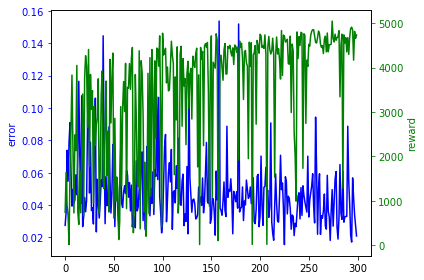

In [59]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot([e[1] for e in results], 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([e[2] for e in results], 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()


In [63]:
print('''Behavarial cloning for {}.
Expert  policy mean reward {:.2f} and std {:.3f}.
Learned policy mean reward {:.2f} and std {:.3f}.'''.format(
    envname, 
    np.mean([e[0] for e in results][-100:]),
    np.std([e[0] for e in results][-100:]),
    np.mean([e[2] for e in results][-100:]),
    np.std([e[2] for e in results][-100:])
))

Behavarial cloning for Ant-v1.
Expert  policy mean reward 4784.29 and std 292.718.
Learned policy mean reward 4298.93 and std 880.772.


In [64]:
args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':1,
        'render': True
    })
#learn_imitatation_learning(ffn, args)
evaluate_imitation_learning(ffn, args)

[2017-11-02 23:58:58,726] Making new env: Ant-v1


[4811.7013012392854]